In [ ]:
import os
import numpy as np
import pandas as pd

import json
import pickle

import cfdna_covid19

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

font_size = 10

# matplotlib.rcParams.keys()
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400,'axes.linewidth':1,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

flatui_3risk = ['#e41a1c','#4daf4a','#ff7f00']
flatui_2cls = ['#377eb8', '#984ea3']

flatui = ['#ff7f00','#4daf4a','#984ea3','#377eb8', '#e41a1c']

sns.set(style='ticks',rc=rc) 
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign


In [ ]:
# print(mpl.matplotlib_fname())
# print(mpl.get_cachedir())

In [4]:
import sklearn
print('sklearn:'+sklearn.__version__)

from sklearn import metrics

sklearn:0.23.2


In [5]:
model_re_root_dir = r'~/model'
feat_types = 'lab, fragl, tss, motif, m2model'

map_name= {'lab': 'LABModel', 'fragl': 'FRAGLModel', 'tss': 'TSSModel', 'motif': 'MOTIFModel', 'm2model': 'M2Model'}
palette = dict(zip([map_name[x.strip()] for x in feat_types.split(',')], flatui))


# Focal loss model


## Model performance as function of number of features ranked by feature importance (SHAP)

{'lab': 14}


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


{'lab': 14, 'fragl': 6}
{'lab': 14, 'fragl': 6, 'tss': 31}
{'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28}
{'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}


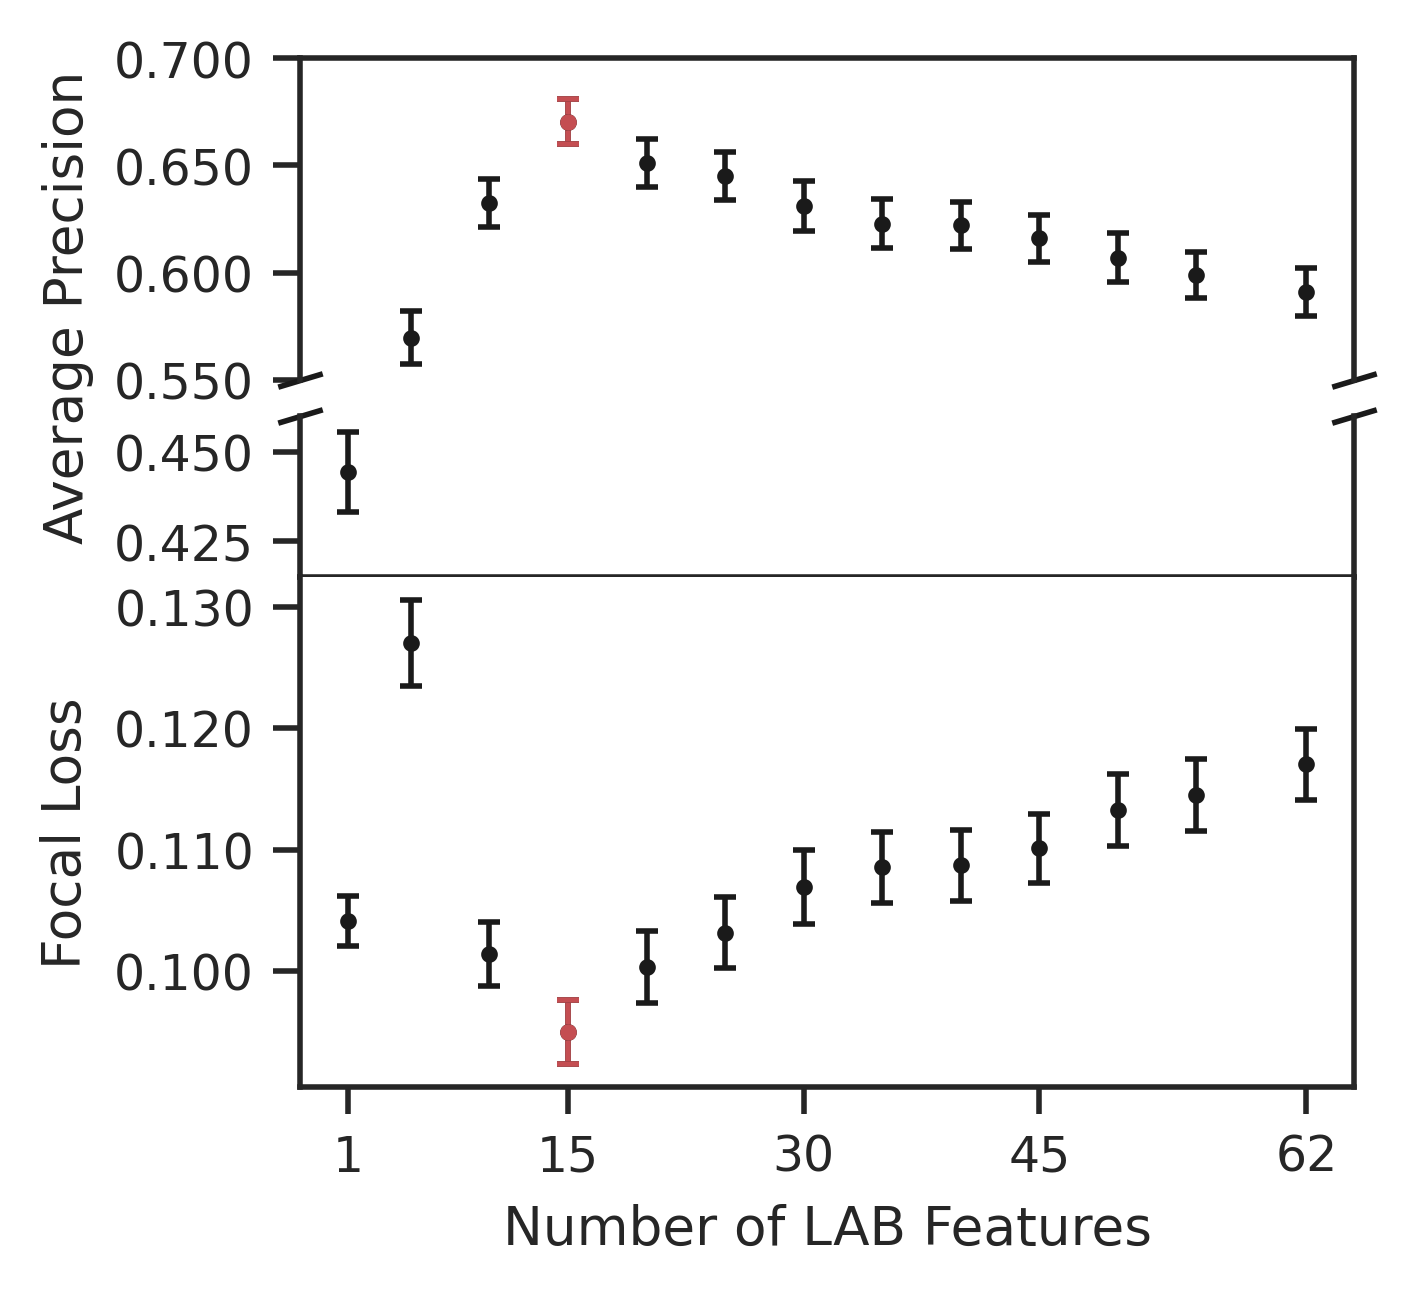

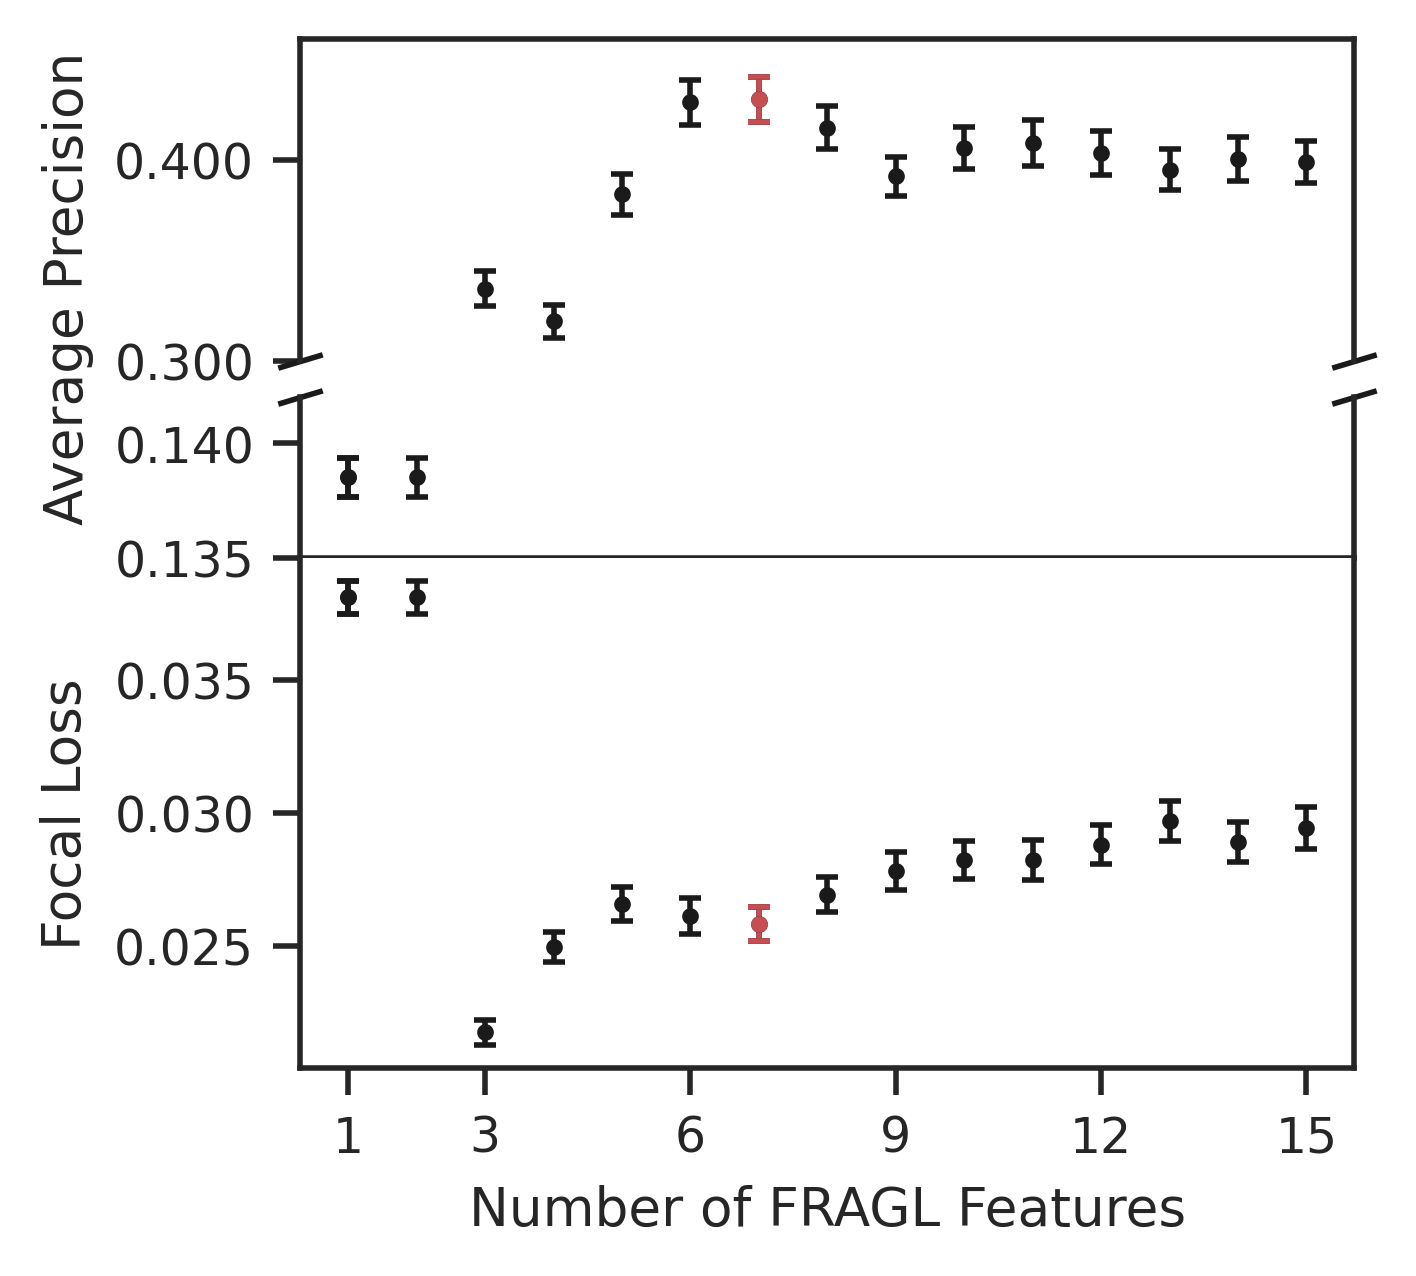

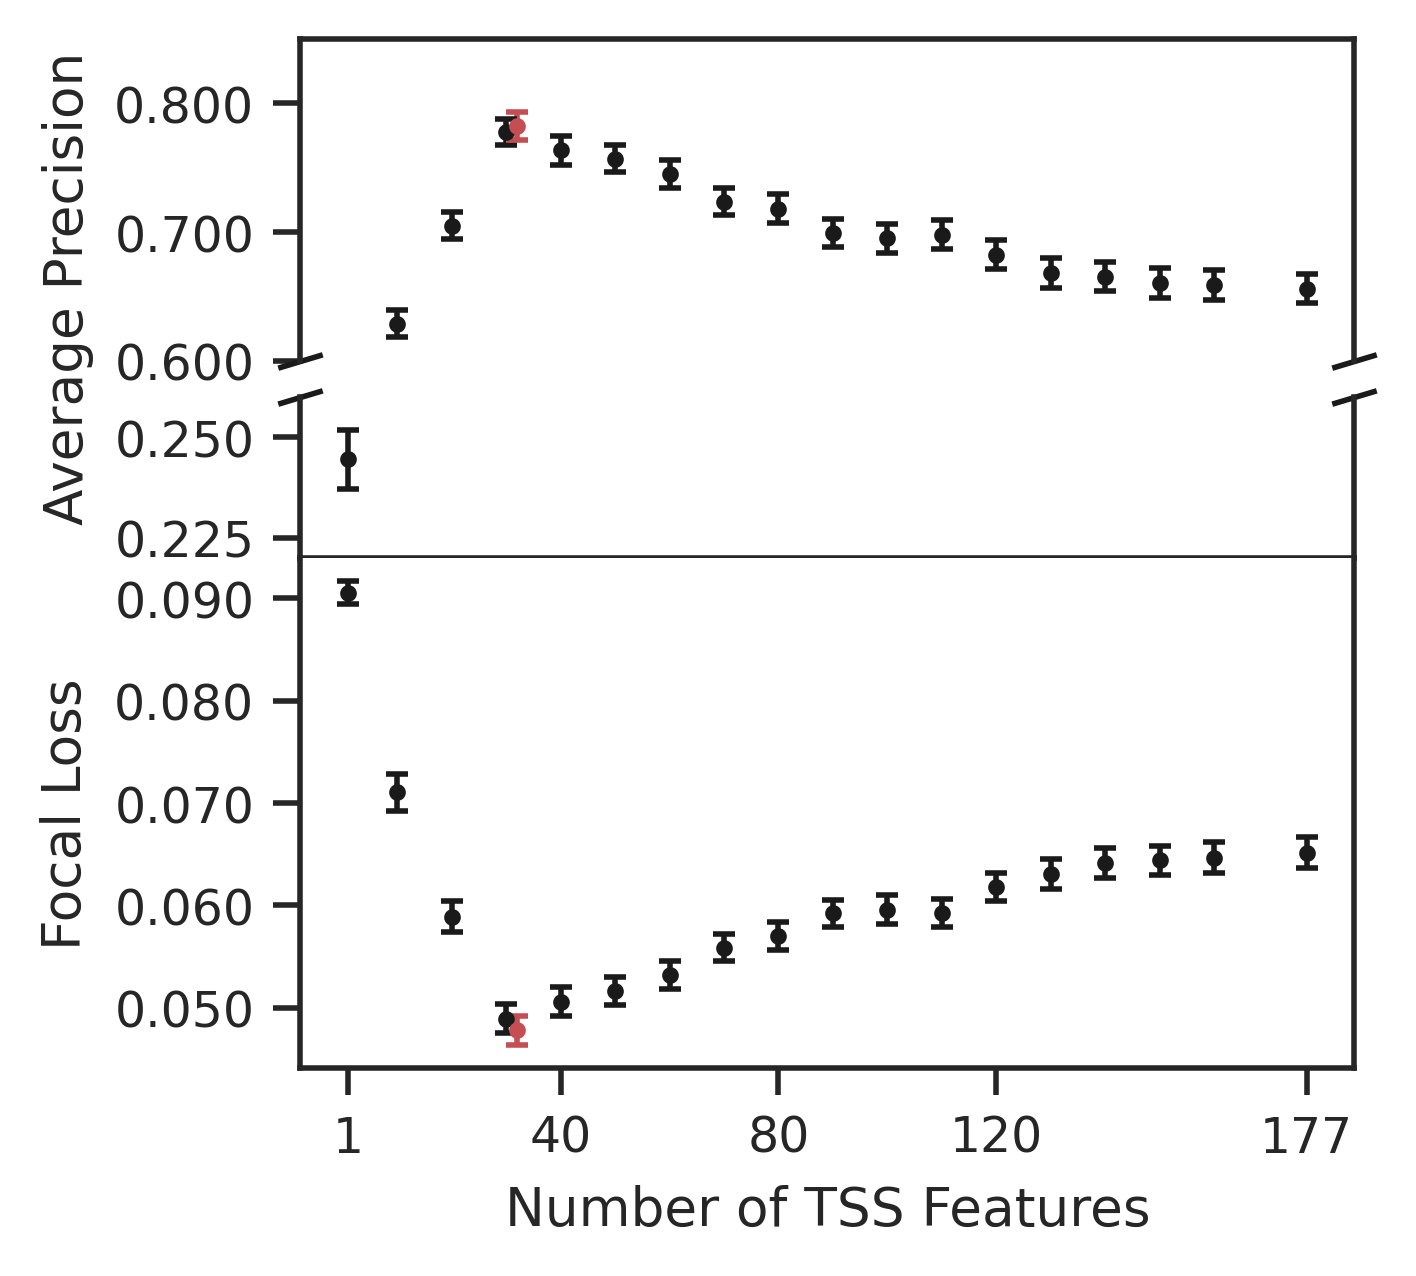

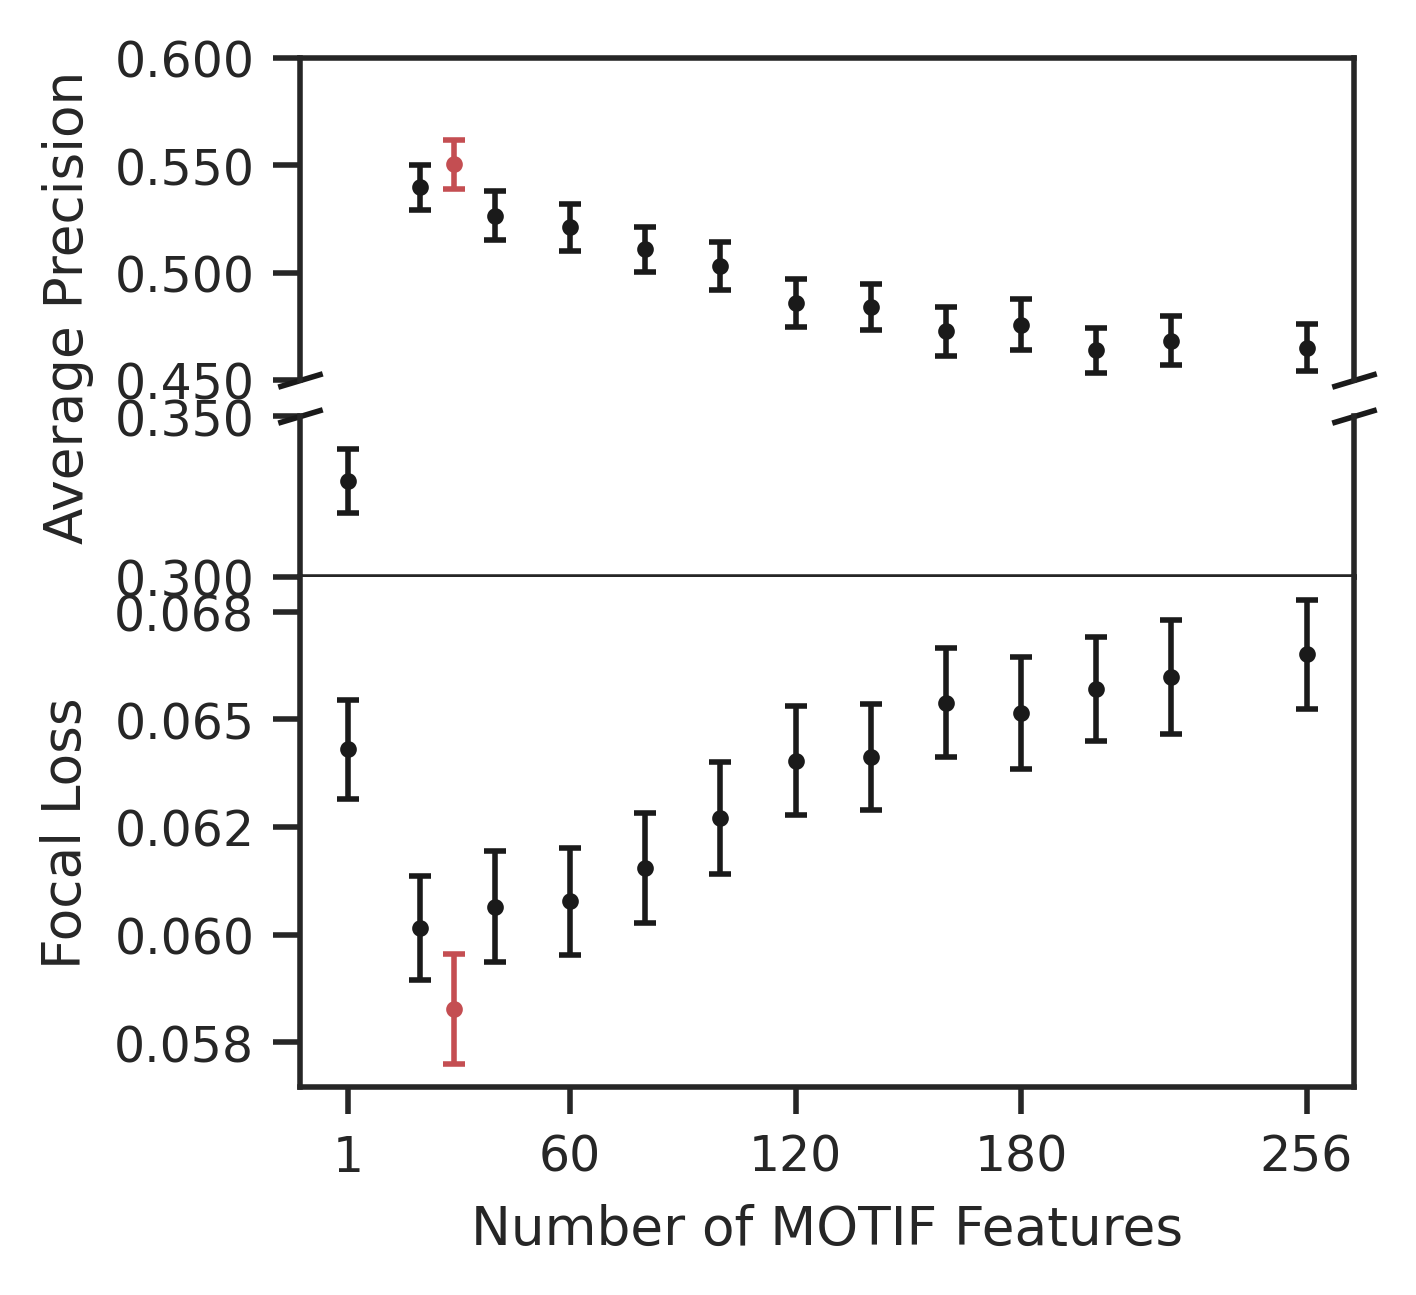

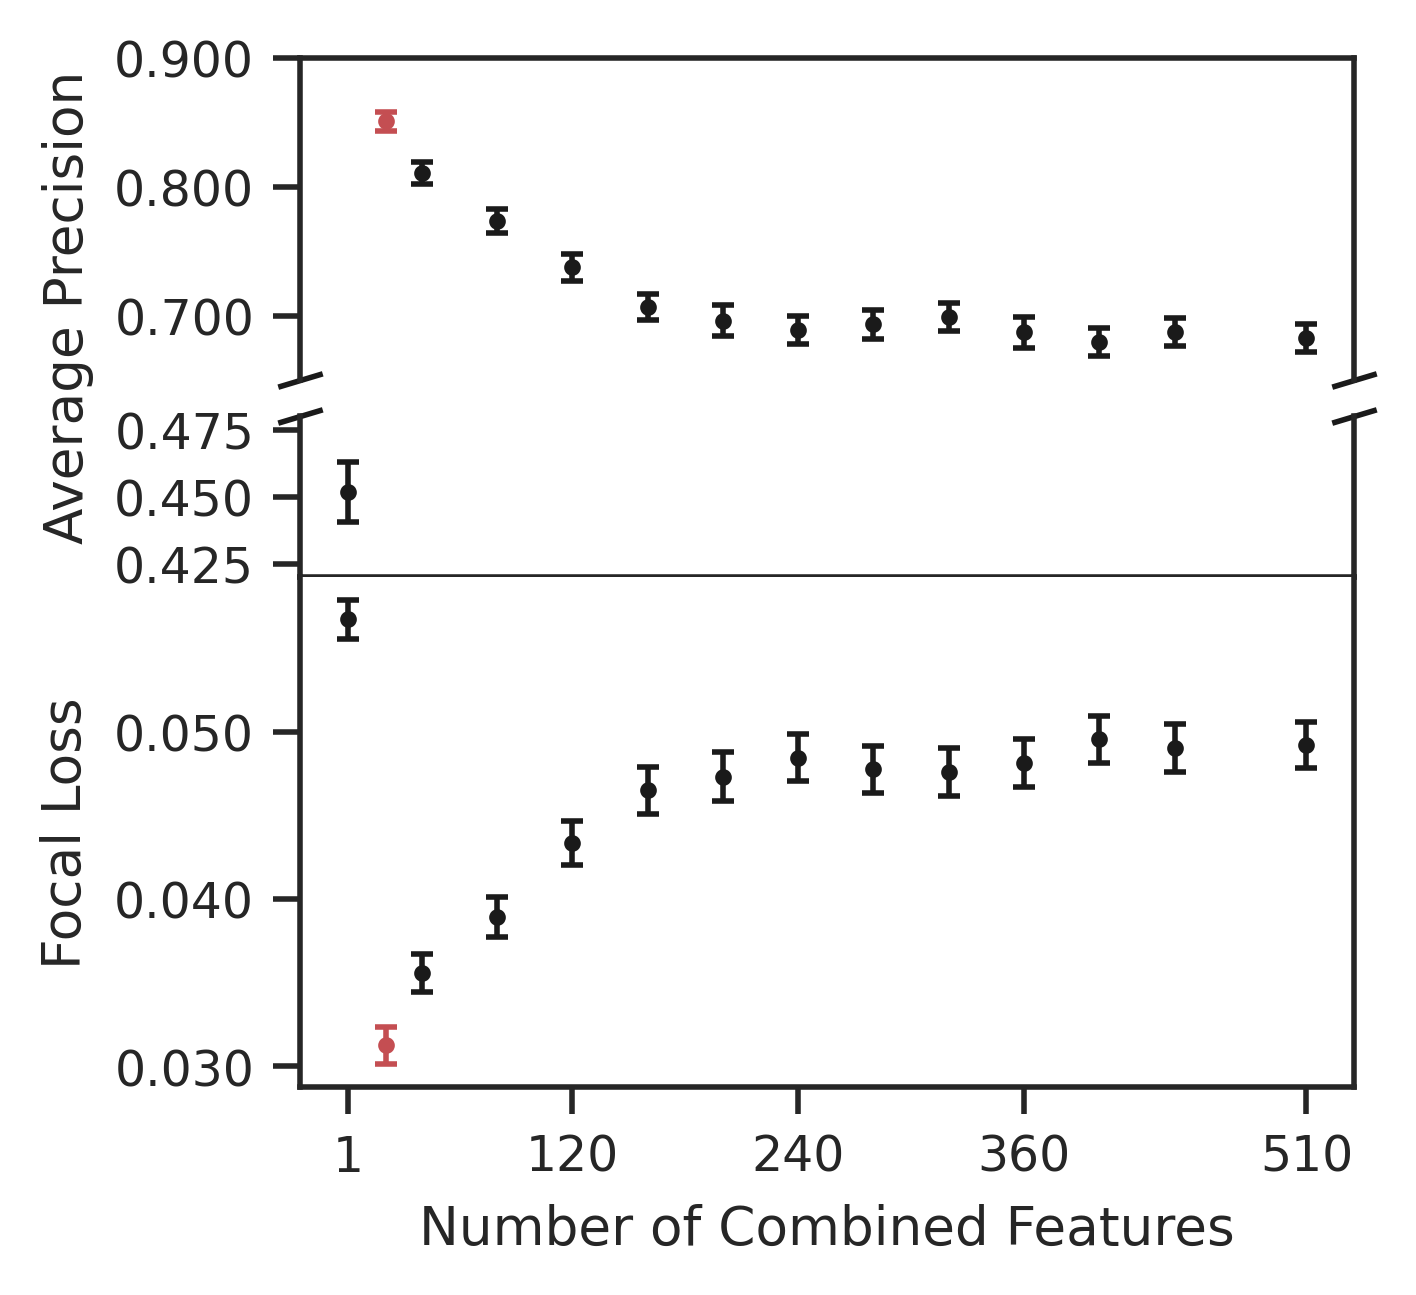

In [7]:
n_feat_idx_step = {'lab': 5, 'fragl': 1, 'tss': 10, 'motif': 20, 'm2model': 40} 
x_tick_step = {'lab': 15, 'fragl': 3, 'tss': 40, 'motif': 60, 'm2model': 120} 

import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

max_feat_idx={}

for i_feat_type in feat_types.split(','):
    
    i_feat_type = i_feat_type.strip()
    i_re_perf_fname = os.path.join(model_re_root_dir, '{}/34_fl_prefeature_performance.pkl'.format(i_feat_type))
    with open(i_re_perf_fname, 'rb') as f:
        perf_feats = pickle.load(f)

    m_auc = []
    std_auc = []
    
    m_focalloss = []
    std_focalloss = []
    
    with open(os.path.join(model_re_root_dir,'{}/31_fl_opt_params-auc.json'.format(i_feat_type)),'r') as f:
        opt_params = json.load(f)
        
    fl_alpha = opt_params['fl_alpha']
    fl_gamma = opt_params['fl_gamma']
    floss = cfdna_covid19.FocalLoss(fl_gamma, alpha=fl_alpha)
    
    for i_feat, (i_feat_ls,i_feat_pred_cv) in enumerate(perf_feats): # the number of features
        i_feat_auc = []
        i_feat_logloss = []
        for imodel, i_trn_pred, i_tst_pred, i_shap in i_feat_pred_cv: # number of iteration
        
            # i_auc = metrics.roc_auc_score(i_tst_pred['new_triage'].values, i_tst_pred['y_pred'].values)
            i_auc = metrics.average_precision_score(i_tst_pred['new_triage'].values, i_tst_pred['y_pred'].values)
            i_logloss = floss(i_tst_pred['new_triage'].values, i_tst_pred['y_pred'].values).mean()
            
            i_feat_auc.append(i_auc)
            i_feat_logloss.append(i_logloss)
    
        m_auc.append(np.mean(i_feat_auc))
        std_auc.append(np.std(i_feat_auc))
        
        m_focalloss.append(np.mean(i_feat_logloss))
        std_focalloss.append(np.std(i_feat_logloss))
    
    max_idx = np.argmax(m_auc)
    max_feat_idx[i_feat_type] = max_idx # the number of features
    print(max_feat_idx)
    
    n_feat_idx = [0]+list(range(n_feat_idx_step[i_feat_type]-1, len(m_auc),n_feat_idx_step[i_feat_type]))
    n_feat_idx[-1]=len(m_auc)-1
    
    x_tick = [0] + list(range(x_tick_step[i_feat_type]-1, len(m_auc),x_tick_step[i_feat_type]))
    x_tick[-1] = len(m_auc)-1
    
    # plot
    fig = plt.figure(figsize=(3.4,2.6))
    gs1 = GridSpec(2, 1, hspace=0.15,height_ratios=[2, 1],bottom=0.50,top=0.999)
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])
    
    gs2 = GridSpec(1, 1, bottom=0.01,top=0.50)
    ax3 = fig.add_subplot(gs2[0])
    # ax3.text(0.5, 0.5, "ax%d" % (3), va="center", ha="center")
    
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5,2.4),
    #                                gridspec_kw={'height_ratios': [2, 1]})
    plt.tight_layout()
    
    ### ax1 and ax2
    ax1.errorbar(np.array(n_feat_idx), np.array(m_auc)[n_feat_idx], (np.array(std_auc)[n_feat_idx])/10.0, 
                     c='k', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
    ax1.errorbar(max_idx, np.array(m_auc)[max_idx], (np.array(std_auc)[max_idx])/10.0, 
                     c='r', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
        
    ax2.errorbar(np.array(n_feat_idx), np.array(m_auc)[n_feat_idx], (np.array(std_auc)[n_feat_idx])/10.0, 
                     c='k', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
    ax2.errorbar(max_idx, np.array(m_auc)[max_idx], (np.array(std_auc)[max_idx])/10.0, 
                     c='r', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
    
    if i_feat_type == 'lab':
        ax1.set_ylim(0.55, 0.7) 
        ax2.set_ylim(0.415, 0.46)
    elif i_feat_type == 'fragl':
        ax1.set_ylim(0.3, 0.46) 
        ax2.set_ylim(0.135, 0.142)
    elif i_feat_type == 'tss':
        ax1.set_ylim(0.60, 0.85) 
        ax2.set_ylim(0.22, 0.26) 
    elif i_feat_type == 'motif':
        ax1.set_ylim(0.45, 0.60) 
        ax2.set_ylim(0.3, 0.35)       
    elif i_feat_type == 'm2model':
        ax1.set_ylim(0.65, 0.90) 
        ax2.set_ylim(0.42, 0.48) 
        
    ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
            
    ax1.spines['bottom'].set_visible(False)
    ax1.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.set_xticks([])
    
    d = .3  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
    ### ax3
    ax3.errorbar(np.array(n_feat_idx), np.array(m_focalloss)[n_feat_idx], (np.array(std_focalloss)[n_feat_idx])/10.0, 
                     c='k', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
    ax3.errorbar(max_idx, np.array(m_focalloss)[max_idx], (np.array(std_focalloss)[max_idx])/10.0, 
                     c='r', lw = 1,capsize = 2, fmt='o',MarkerSize=2)
    ax3.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
    
    ax3.set_xticks(x_tick)
    xtick_lab = np.array(x_tick)+1
    ax3.set_xticklabels(xtick_lab) 
    ax3.spines['top'].set_visible(False)
    if i_feat_type=='m2model':
        ax3.set_xlabel('Number of Combined Features')
    else:
        ax3.set_xlabel('Number of {} Features'.format(i_feat_type.upper()))
    ax3.set_ylabel('Focal Loss')
    
    fig.text(-0.065, 0.76, 'Average Precision', va='center', rotation='vertical')
    # fig.subplots_adjust(hspace=0.15)  # adjust space between axes
        
    # plt.xlabel('Number of Features')
    
    plt.savefig("results_plt/feat_ap_rank_{}_n{}.pdf".format(i_feat_type,max_idx+1), dpi=400, bbox_inches='tight',format='pdf')
    
    

AP:

max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}

## Random train/test split 100 iterations


In [49]:
# Those results obtained above
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}

for i_idx, i_feat_type in enumerate(feat_types.split(',')):
    
    # if i_idx>0:
    #     break
    
    i_feat_type = i_feat_type.strip()
    i_re_perf_fname = os.path.join(model_re_root_dir, '{}/34_fl_prefeature_performance.pkl'.format(i_feat_type))
    with open(i_re_perf_fname, 'rb') as f:
        perf_feats = pickle.load(f)
    i_feat_ls, i_feat_pred_cv = perf_feats[max_feat_idx_ap[i_feat_type]]
    
    iters_tst_pred = None
    for res_idx, (imodel, i_trn_pred, i_tst_pred, i_shap) in enumerate(i_feat_pred_cv): # 100 iters
        
        i_tst_pred_n= i_tst_pred.copy() # 1：train results， 2: tst result
        i_tst_pred_n.rename(columns={"y_pred": "tst_pred{}".format(res_idx)}, inplace=True)
        
        if res_idx == 0:
            iters_tst_pred = i_tst_pred_n # test
        else:
            iters_tst_pred=iters_tst_pred.merge(i_tst_pred_n, how='outer', on=['ind','new_triage'])
            
    iters_tst_pred.to_csv('results_plt/100iters_tst_preds_399pat_{}_{}.csv'.format(i_feat_type,max_feat_idx_ap[i_feat_type]), sep='\t', index=False)


In [ ]:
# example
iters_tst_pred


## ROC curve

In [15]:
def tst_roc(iter100_tst_pred):
    
    from sklearn import metrics
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    
    precisions = []
    aps = []
    mean_recalls = np.linspace(0, 1, 200)
    
    thres=[]
    
    for it in range(100):
        pred_col_name = 'tst_pred{}'.format(it)
        
        i_tst_pred = iter100_tst_pred.loc[iter100_tst_pred[pred_col_name].notnull(), ['new_triage',pred_col_name]]
        
        i_y_tst_true = i_tst_pred['new_triage'].values
        i_y_tst_pred = i_tst_pred[pred_col_name].values
        
        i_fpr, i_tpr, i_thre = metrics.roc_curve(i_y_tst_true, i_y_tst_pred) #drop_intermediate=False)
        
        i_auc = metrics.auc(i_fpr, i_tpr)
        
        interp_tpr = np.interp(mean_fpr, i_fpr, i_tpr)
        interp_tpr[0] = 0.0
        
        interp_thres = np.interp(mean_fpr, i_fpr, i_thre)
        
        tprs.append(interp_tpr)
        aucs.append(i_auc)
        
        thres.append(interp_thres)
        
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    
    mean_auc = np.mean(aucs)#auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    mean_thres = np.mean(thres, axis=0)
    std_thres = np.std(thres,axis=0)
    
    return mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc,mean_thres,std_thres

{'lab': 0.14114473980392142, 'fragl': 0.2769292659360136, 'tss': 0.11831944023355545, 'motif': 0.15140567337020586, 'm2model': 0.14355239673919232}


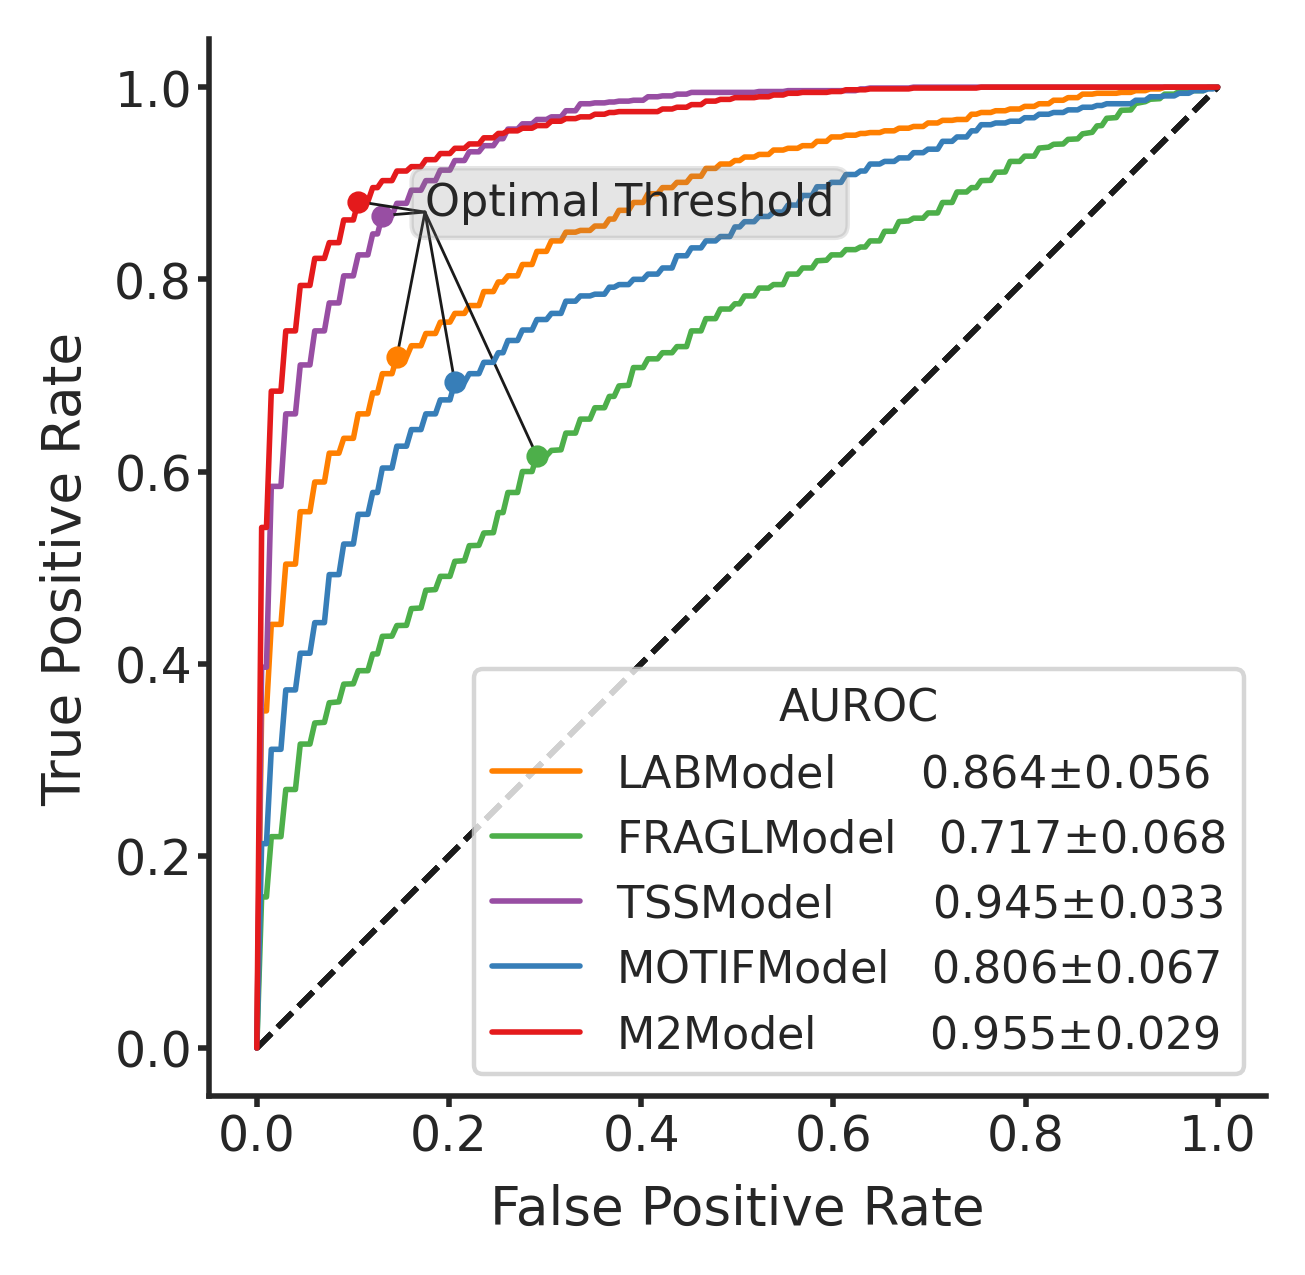

In [31]:

fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))

max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
space_title_name= {'lab': 6, 'fragl': 3, 'tss': 7, 'motif': 3, 'm2model': 8}

opt_thres = {}

for i_idx, i_feat_type in enumerate(feat_types.split(',')):
    
    i_feat_type = i_feat_type.strip()
    
    iters_tst_pred = pd.read_csv('results_plt/100iters_tst_preds_399pat_{}_{}.csv'.format(i_feat_type,max_feat_idx_ap[i_feat_type]), sep='\t')
    
    mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc,mean_thres,std_thres = tst_roc(iters_tst_pred) 
    
    # optimal threshold
    # Youden’s J statistic.
    J = mean_tpr-mean_fpr
    ix = np.argmax(J)
        
    opt_thres[i_feat_type] = mean_thres[ix]
    
    ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="k", alpha=0.8)
    
    lb = map_name[i_feat_type] + ' '*space_title_name[i_feat_type]+r'{0:.3f}$\pm${1:.3f}'.format(mean_auc,std_auc)
    ax.plot(mean_fpr, mean_tpr, label='{0}'.format(lb), color=flatui[i_idx], lw=1)
    
    ax.plot([mean_fpr[ix], 0.13+0.045], [mean_tpr[ix], 0.87], color='k', linestyle='-', lw=0.5)
    if i_idx == 2:
        t=ax.text(0.13+0.045, mean_tpr[ix], 'Optimal Threshold', fontsize=8)
        t.set_bbox(dict(facecolor='grey', alpha=0.2, edgecolor='grey',boxstyle="round"))
        
    ax.plot(mean_fpr[ix], mean_tpr[ix], 'o', color=flatui[i_idx], markersize=3)
    
ax.set(xlim=[-0.05, 1.05],ylim=[-0.05, 1.05])
sns.despine()
ax.set_aspect('equal','box')
ax.legend(loc="lower right",title='AUROC',title_fontsize=8,fontsize=8)#,frameon=False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.tick_params(direction='out', length=2, pad=1, width=1)

plt.savefig("results_plt/feat_opt_roc_all.pdf", dpi=400, bbox_inches='tight', pad_inches = 0.1)

print(opt_thres)

opt_thres={'lab': 0.14114473980392142,
 'fragl': 0.2769292659360136,
 'tss': 0.11831944023355545,
 'motif': 0.15140567337020586,
 'm2model': 0.14355239673919232}

## Other metrics

### Decision Curve

In [72]:
# mean pred values for Decision Curve
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}

mean_tst_pred_all = None

for i_idx, i_feat_type in enumerate(feat_types.split(',')):
    
    # if i_idx>0:
    #     break
    
    i_feat_type = i_feat_type.strip()
    
    iters_tst_pred = pd.read_csv('results_plt/100iters_tst_preds_399pat_{}_{}.csv'.format(i_feat_type,max_feat_idx_ap[i_feat_type]), sep='\t')
    
    tmp_tst_pred = iters_tst_pred[['ind','new_triage']].copy()
    tmp_tst_pred['mean_tst_pred_{}'.format(i_feat_type)] = iters_tst_pred.iloc[:,2:].mean(axis=1)
        
    if i_idx == 0:
        mean_tst_pred_all=tmp_tst_pred
    else:
        
        mean_tst_pred_all = mean_tst_pred_all.merge(tmp_tst_pred, on=['ind','new_triage'])

mean_tst_pred_all.to_csv('results_plt/100iters_tst_mean_preds_399pat_allmethods.csv',sep='\t', index=False)

In [ ]:
mean_tst_pred_all

### Performance metrics

#### Calculation

In [30]:
import cfdna_covid19
def cal_metrics(iter100_tst_pred, i_feat_type, opt_thre_val=None):
    
    auroc=[]
    aupr=[]
    avgpr = []
    bsl=[]
    fls=[]
    
    opt_thress = []
    
    tn50s=[]
    fp50s=[]
    fn50s=[]
    tp50s=[]
    
    tn_opts=[]
    fp_opts=[]
    fn_opts=[]
    tp_opts=[]
    
    prec_50 = []
    prec_opt = []
    recal_50 = []
    recal_opt = []
    f1_50 = []
    f1_opt = []
    mcc_50 = []
    mcc_opt = []
    
    spe_50 = []
    spe_opt = []
    bacc_50 = []
    bacc_opt = []
    
    npv_50 = []
    npv_opt = []
    
    fdr_50 = []
    fdr_opt = []
    
    with open(os.path.join(model_re_root_dir,'{}/31_fl_opt_params-auc.json'.format(i_feat_type)),'r') as f:
        opt_params = json.load(f)
        
    fl_alpha = opt_params['fl_alpha']
    fl_gamma = opt_params['fl_gamma']
    
    floss = cfdna_covid19.FocalLoss(fl_gamma, alpha=fl_alpha)
    
    for it in range(100):
        pred_col_name = 'tst_pred{}'.format(it)
        
        i_tst_pred = iter100_tst_pred.loc[iter100_tst_pred[pred_col_name].notnull(), ['new_triage',pred_col_name]]
        
        i_y_tst_true = i_tst_pred['new_triage'].values
        i_y_tst_pred = i_tst_pred[pred_col_name].values
        
        i_fpr, i_tpr, i_thre = metrics.roc_curve(i_y_tst_true, i_y_tst_pred)
        if opt_thre_val is None:
            J = i_tpr-i_fpr
            ix = np.argmax(J)
            opt_thre = i_thre[ix]
        else:
            opt_thre=opt_thre_val
        
        opt_thress.append(opt_thre)
        
        # AUROC
        auroc.append(metrics.auc(i_fpr,i_tpr))
        
        # AUPR
        i_prec, i_recal, i_thres = metrics.precision_recall_curve(i_y_tst_true, i_y_tst_pred)
        aupr.append(metrics.auc(i_recal,i_prec))
        
        # AVerage PR
        avgpr.append(metrics.average_precision_score(i_y_tst_true, i_y_tst_pred))
        
        # Brier score loss
        bsl.append(metrics.brier_score_loss(i_y_tst_true, i_y_tst_pred))
        
        # Focal Loss
        fls.append(floss(i_y_tst_true, i_y_tst_pred).mean())
        
        i_tst_pred_50 = np.where(i_y_tst_pred<0.5, 0, 1)
        i_tst_pred_opt = np.where(i_y_tst_pred<opt_thre, 0, 1)
        
        tn50, fp50, fn50, tp50 = metrics.confusion_matrix(i_y_tst_true, i_tst_pred_50).ravel()
        tn_opt, fp_opt, fn_opt, tp_opt = metrics.confusion_matrix(i_y_tst_true, i_tst_pred_opt).ravel()
        tn50s.append(tn50)
        fp50s.append(fp50)
        fn50s.append(fn50)
        tp50s.append(tp50)
    
        tn_opts.append(tn_opt)
        fp_opts.append(fp_opt)
        fn_opts.append(fn_opt)
        tp_opts.append(tp_opt)
        
        # Precision50 / PPV
        prec_50.append(metrics.precision_score(i_y_tst_true, i_tst_pred_50))
        # Precision_opt_threshold
        prec_opt.append(metrics.precision_score(i_y_tst_true, i_tst_pred_opt))
        
        # Recall50 / sensitivity
        recal_50.append(metrics.recall_score(i_y_tst_true, i_tst_pred_50))
        # Recall_opt
        recal_opt.append(metrics.recall_score(i_y_tst_true, i_tst_pred_opt))
        
        # F1_50
        f1_50.append(metrics.f1_score(i_y_tst_true, i_tst_pred_50))
        # F1_opt
        f1_opt.append(metrics.f1_score(i_y_tst_true, i_tst_pred_opt))
        
        # Matthews correlation coefficient (MCC)_50
        mcc_50.append(metrics.matthews_corrcoef(i_y_tst_true, i_tst_pred_50))
        # Matthews correlation coefficient (MCC)_opt
        mcc_opt.append(metrics.matthews_corrcoef(i_y_tst_true, i_tst_pred_opt))
        
        # Specificity_50
        spe_50.append(tn50*1.0 / (tn50+fp50))
        # print('tn50+fp50: ',tn50+fp50)
        # Specificity_opt
        spe_opt.append(tn_opt*1.0 / (tn_opt+fp_opt))
        # print('tn_opt+fp_opt: ',tn_opt+fp_opt)
        
        # balance acc 50
        bacc_50.append(metrics.balanced_accuracy_score(i_y_tst_true, i_tst_pred_50))
        # balance acc opt
        bacc_opt.append(metrics.balanced_accuracy_score(i_y_tst_true, i_tst_pred_opt))
        
        # NPV_50
        npv_50.append(tn50*1.0 / (tn50+fn50))
        # print('tn50+fn50: ',tn50+fn50)
        # NPV_opt
        npv_opt.append(tn_opt*1.0 / (tn_opt+fn_opt))
        # print('tn_opt+fn_opt: ',tn_opt+fn_opt)
        
        fdr_50.append(fp50*1.0/(tp50+fp50))
        # print('tp50+fp50: ',tp50+fp50)
        fdr_opt.append(fp_opt*1.0/(tp_opt+fp_opt))
        # print('tp_opt+fp_opt: ',tp_opt+fp_opt)
    
    return pd.DataFrame({'Model':[map_name[i_feat_type]]*100,'AUROC':auroc,'AUPR':aupr,'AvgPR':avgpr,'Brier':bsl,'Focal_Loss':fls,'Opt_thre':opt_thress,
                         'TN50':tn50s, 'FP50':fp50s, 'FN50':fn50s, 'TP50':tp50s,
                         'TN_opt':tn_opts, 'FP_opt':fp_opts, 'FN_opt':fn_opts, 'TP_opt':tp_opts,
                        'Precision50':prec_50, 'Precision_opt':prec_opt, 'Recall50':recal_50, 'Recall_opt':recal_opt,
                        'F1_50':f1_50, 'F1_opt':f1_opt, 'MCC50':mcc_50, 'MCC_opt':mcc_opt,'Spe50':spe_50, 'Spe_opt':spe_opt,
                        'BACC50':bacc_50, 'BACC_opt':bacc_opt, 'NPV50':npv_50, 'NPV_opt':npv_opt, 'FDR50':fdr_50, 'FDR_opt':fdr_opt})  
    
    
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)


In [31]:
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}

opt_thres={'lab': 0.14114473980392142,'fragl': 0.2769292659360136,'tss': 0.11831944023355545,'motif': 0.15140567337020586,'m2model': 0.14355239673919232}


i_metrics_pds=[]

for i_idx, i_feat_type in enumerate(feat_types.split(',')):
    
    # if i_idx>0:
    #     break
    i_feat_type = i_feat_type.strip()
    
    iters_tst_pred = pd.read_csv('results_plt/100iters_tst_preds_399pat_{}_{}.csv'.format(i_feat_type,max_feat_idx_ap[i_feat_type]), sep='\t')
    # i_metrics_pds.append(cal_metrics(iters_tst_pred, i_feat_type))
    i_metrics_pds.append(cal_metrics(iters_tst_pred, i_feat_type, opt_thre_val=opt_thres[i_feat_type]))   

metrics_100iters_df = pd.concat(i_metrics_pds, ignore_index=True)
metrics_100iters_df.to_csv('results_plt/100iters_tst_preds_399pat_allmethods_metrics.csv', sep='\t', index=False)

#### Plots and Table

In [6]:
metrics_100iters_df = pd.read_csv('results_plt/100iters_tst_preds_399pat_allmethods_metrics.csv', sep='\t')
metrics_100iters_df

,Model,AUROC,AUPR,AvgPR,Brier,Focal_Loss,Opt_thre,TN50,FP50,FN50,...,MCC50,MCC_opt,Spe50,Spe_opt,BACC50,BACC_opt,NPV50,NPV_opt,FDR50,FDR_opt
0,LABModel,0.754941,0.610931,0.618168,0.075230,0.111363,0.141145,68,1,5,...,0.647103,0.414477,0.985507,0.898551,0.765481,0.722003,0.931507,0.925373,0.142857,0.538462
1,LABModel,0.905138,0.708713,0.722617,0.063061,0.071792,0.141145,68,1,5,...,0.647103,0.611261,0.985507,0.927536,0.765481,0.827404,0.931507,0.955224,0.142857,0.384615
2,LABModel,0.762846,0.479819,0.503787,0.100329,0.146762,0.141145,65,4,6,...,0.432210,0.413707,0.942029,0.855072,0.698287,0.745718,0.915493,0.936508,0.444444,0.588235
3,LABModel,0.922266,0.737616,0.746006,0.070495,0.076449,0.141145,65,4,5,...,0.507612,0.567176,0.942029,0.869565,0.743742,0.843874,0.928571,0.967742,0.400000,0.500000
4,LABModel,0.852437,0.633244,0.644688,0.080772,0.102064,0.141145,66,3,6,...,0.471870,0.484807,0.956522,0.898551,0.705534,0.767457,0.916667,0.939394,0.375000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,M2Model,0.932806,0.720226,0.734779,0.063957,0.045798,0.143552,68,1,5,...,0.647103,0.580336,0.985507,0.913043,0.765481,0.820158,0.931507,0.954545,0.142857,0.428571
496,M2Model,0.922266,0.811379,0.816801,0.058241,0.033513,0.143552,68,1,6,...,0.575353,0.747156,0.985507,0.956522,0.720026,0.887352,0.918919,0.970588,0.166667,0.250000
497,M2Model,0.997365,0.983402,0.984160,0.026725,0.010733,0.143552,69,0,2,...,0.891703,0.950464,1.000000,0.985507,0.909091,0.992754,0.971831,1.000000,0.000000,0.083333
498,M2Model,0.986825,0.934601,0.937190,0.044577,0.021231,0.143552,69,0,5,...,0.713162,0.776830,1.000000,0.985507,0.772727,0.856390,0.932432,0.957746,0.000000,0.111111


In [7]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

##### Metrics (Plot)

[(0.32198062111607, 0.11121790830363898), (0.514541096183023, 0.10355782888292495), (0.7496940153082602, 0.05261674796613739), (0.4321965156932178, 0.09518379691953928), (0.6299567346236532, 0.07075296966320747)]


Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results


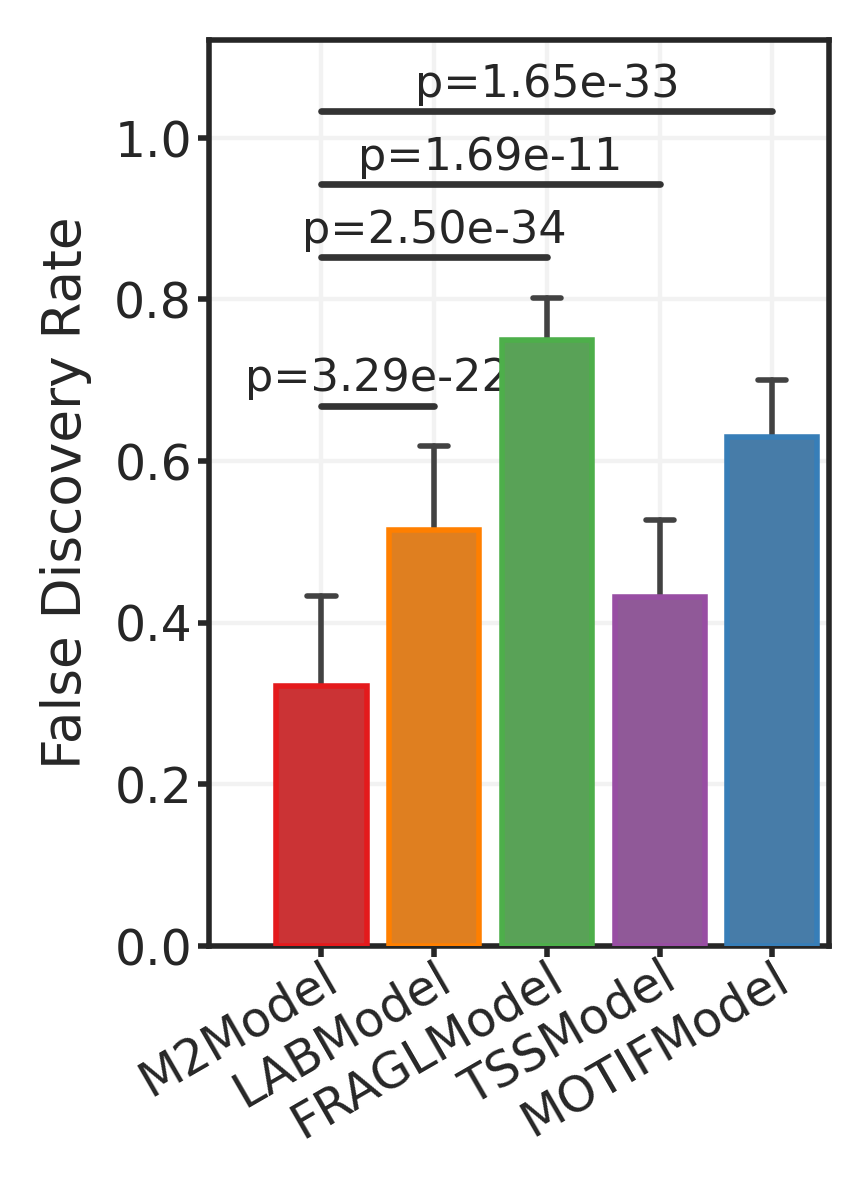

In [19]:
metrics_names=['AUROC','AvgPR','AUPR','Brier','Focal_Loss',
               'Recall_opt','Spe_opt','Precision_opt','NPV_opt',
              'MCC_opt','BACC_opt','FDR_opt']
full_names = {'AUROC':'AUROC','AvgPR':'Average Precision','AUPR':'AUPR','Brier':'Brier Score','Focal_Loss':'Focal Loss',
             'Recall_opt':'Sensitivity','Spe_opt':'Specificity','Precision_opt':'PPV','NPV_opt':'NPV',
             'MCC_opt':'MCC','BACC_opt':'Balanced Accuracy','FDR_opt':'False Discovery Rate'}

metrics_name=metrics_names[11] # 11

orders= ['M2Model','LABModel', 'FRAGLModel', 'TSSModel', 'MOTIFModel']

edclrs = ['#e41a1c','#ff7f00','#4daf4a','#984ea3','#377eb8']

fig, axs = plt.subplots(1,1,figsize=(2,3))

plot_param={
    'data':metrics_100iters_df,
    'x':'Model',
    'y':metrics_name,
    'order':orders,
    'orient':'v'
}

# sns.stripplot(**plot_param, ax=axs,palette=palette,size=1)
# axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.8)

axa = sns.barplot(**plot_param,ax=axs,
                  palette=palette, 
                  linewidth=1,
                  ci='sd', # 68: SEM (The Standard Error of Mean)
                  capsize=0.25,errwidth=1,
                  zorder=5,
                  # facecolor='w',
                  edgecolor=edclrs) 

# for i,artist in enumerate(axa.artists):
#     # Set the linecolor on the artist to the facecolor, and set the facecolor to None
#     col = artist.get_facecolor()
#     artist.set_edgecolor(col)
#     artist.set_facecolor('None')

#     # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
#     # Loop over them here, and use the same colour as above
#     for j in range(i*5,i*5+5):
#         line = axa.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)

m2model_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==orders[0],metrics_name].values
lab_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==orders[1],metrics_name].values
fragl_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==orders[2],metrics_name].values
tss_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==orders[3],metrics_name].values
motif_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==orders[4],metrics_name].values

mean_vals = [m2model_values.mean(),
             lab_values.mean(),
             fragl_values.mean(),
             tss_values.mean(),
             motif_values.mean()
            ]
std_vals = [m2model_values.std(),
             lab_values.std(),
             fragl_values.std(),
             tss_values.std(),
             motif_values.std()
            ]
print(list(zip(mean_vals,std_vals)))


pvalues = [
    mannwhitneyu(m2model_values, lab_values, alternative="two-sided").pvalue,
    mannwhitneyu(m2model_values, fragl_values, alternative="two-sided").pvalue,
    mannwhitneyu(m2model_values, tss_values, alternative="two-sided").pvalue,
    mannwhitneyu(m2model_values, motif_values, alternative="two-sided").pvalue
]
formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

anno_pairs= [(orders[0], orders[1]),(orders[0], orders[2]),(orders[0], orders[3]),(orders[0], orders[4])]
annot = Annotator(axa, pairs=anno_pairs, **plot_param)
annot.reset_configuration()
annot.set_custom_annotations(formatted_pvalues)
annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
annot.annotate(line_offset=0.01)

xticklabels = axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
axa.set_xlabel('')
axa.set_xlim((-1,4.5))
axa.set_ylabel(full_names[metrics_name])
# sns.despine()
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)

axa.tick_params(direction='out', length=2, pad=1, width=1)

plt.grid(color='0.95')
# plt.savefig("results_plt/feat_opt_perf_compr_{}.pdf".format(metrics_name), dpi=400, bbox_inches='tight', pad_inches = 0.1)
plt.savefig("results_plt/feat_opt_perf_compr_{}.pdf".format(metrics_name), dpi=400, bbox_inches='tight', format='pdf')


AUPR(mean, std):

[(0.8450123443842571, 0.07917043851572812), (0.6593520436740882, 0.1097261823325415), (0.4091835742870496, 0.11720816405191134), (0.7681533943325664, 0.11923214770924113), (0.5322823353081293, 0.12008758214195624)]

Brier

[(0.05176783308805497, 0.012577510782225182), (0.07751877204196181, 0.016842292162125964), (0.11768880127399743, 0.008822903625989859), (0.0642954965573246, 0.012825338358626776), (0.09069067493446376, 0.012121134032741877)]


##### Metrics (Table) and Confusion Matric

In [44]:
# Confusion Matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, save_fname=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    # plt.figure(figsize=(2, 3))
    fig, axa = plt.subplots(1,1,figsize=(3.2, 3.6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, fontsize=10, rotation=30, ha='right',rotation_mode="anchor")
        
        xticklabels = axa.get_xticklabels()
        for i, xticklabel in enumerate(xticklabels):
            xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
        
        plt.yticks(tick_marks, target_names,fontsize=10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center", verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black", fontsize=10)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black",fontsize=10)


    plt.tight_layout()
    plt.ylabel('Reference',rotation=90,fontsize=10)
    plt.xlabel('Predicted',fontsize=10)
    
    plt.tick_params(direction='out', length=2, pad=1, width=1)
    
    if save_fname is not None:
        plt.savefig(save_fname, dpi=400, bbox_inches='tight')
    plt.show()

In [45]:
# optimal threshold from ROC 
opt_thres={'lab': 0.14114473980392142,
 'fragl': 0.2769292659360136,
 'tss': 0.11831944023355545,
 'motif': 0.15140567337020586,
 'm2model': 0.14355239673919232}

mean_tst_pred_all = pd.read_csv('results_plt/100iters_tst_mean_preds_399pat_allmethods.csv',sep='\t')

y_true_pdist = mean_tst_pred_all['new_triage'].values

perf_mean_label={}
perf_mean_label['y_true']=y_true_pdist

y_pred_lab_pdist = mean_tst_pred_all['mean_tst_pred_lab'].values
y_pred_lab_label = np.where(y_pred_lab_pdist<opt_thres['lab'], 0, 1)
perf_mean_label['lab']=y_pred_lab_label

y_pred_fragl_pdist = mean_tst_pred_all['mean_tst_pred_fragl'].values
y_pred_fragl_label = np.where(y_pred_fragl_pdist<opt_thres['fragl'], 0, 1)
perf_mean_label['fragl']=y_pred_fragl_label

y_pred_tss_pdist = mean_tst_pred_all['mean_tst_pred_tss'].values
y_pred_tss_label = np.where(y_pred_tss_pdist<opt_thres['tss'], 0, 1)
perf_mean_label['tss']=y_pred_tss_label

y_pred_motif_pdist = mean_tst_pred_all['mean_tst_pred_motif'].values
y_pred_motif_label = np.where(y_pred_motif_pdist<opt_thres['motif'], 0, 1)
perf_mean_label['motif']=y_pred_motif_label

y_pred_m2model_pdist = mean_tst_pred_all['mean_tst_pred_m2model'].values
y_pred_m2model_label = np.where(y_pred_m2model_pdist<opt_thres['m2model'], 0, 1)
perf_mean_label['m2model']=y_pred_m2model_label

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


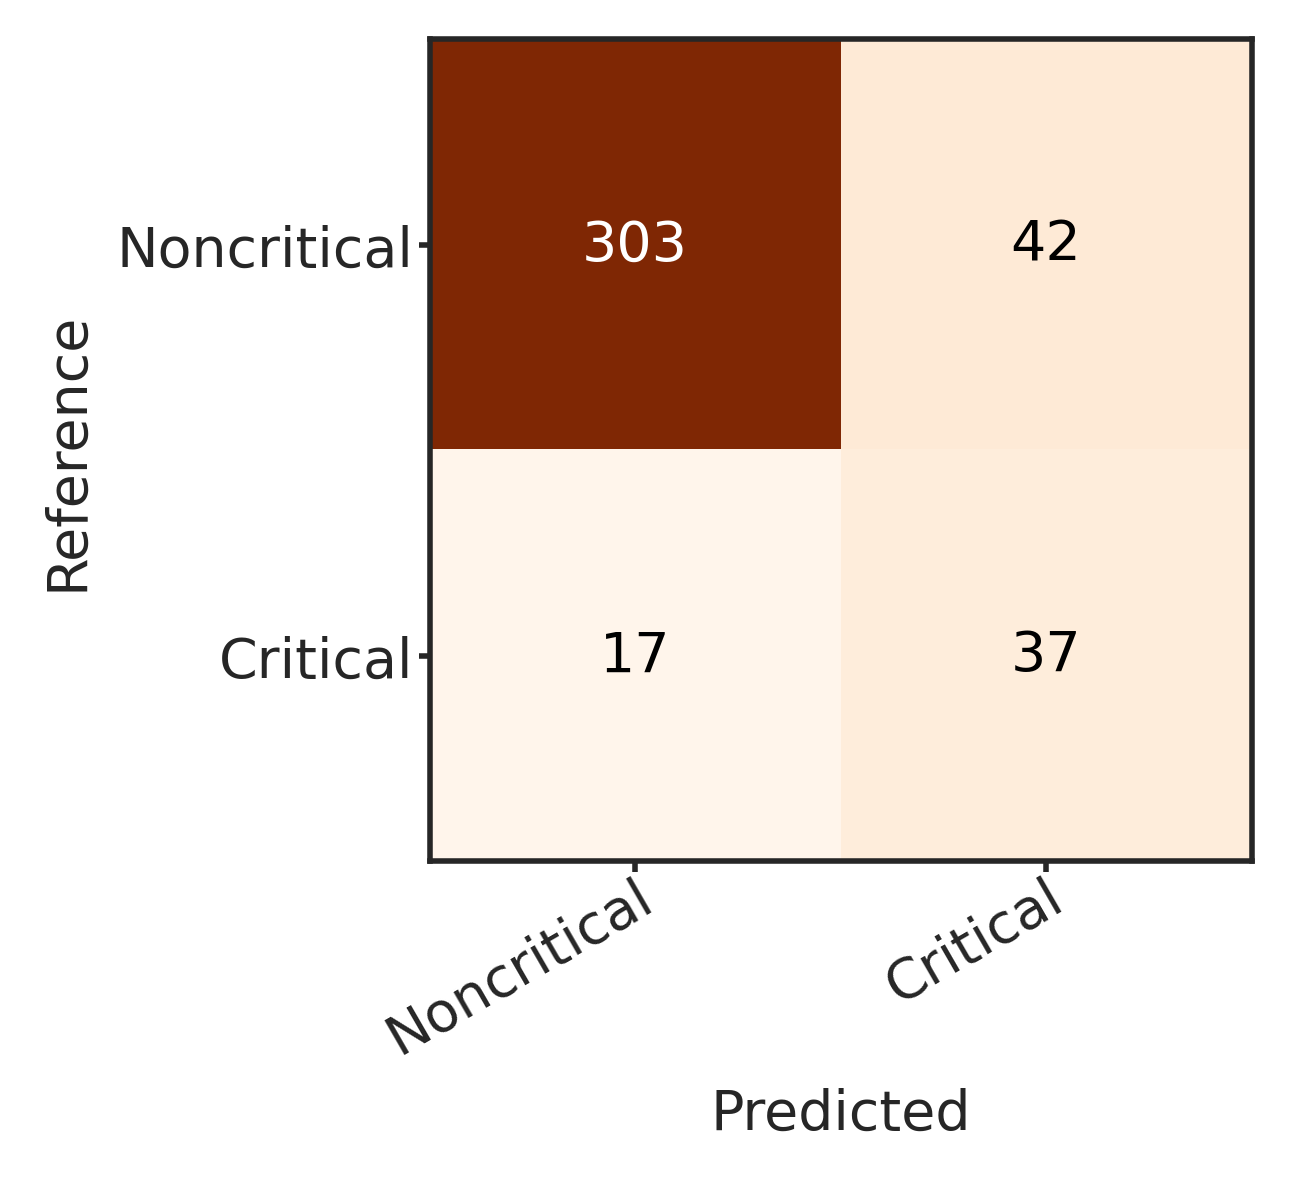

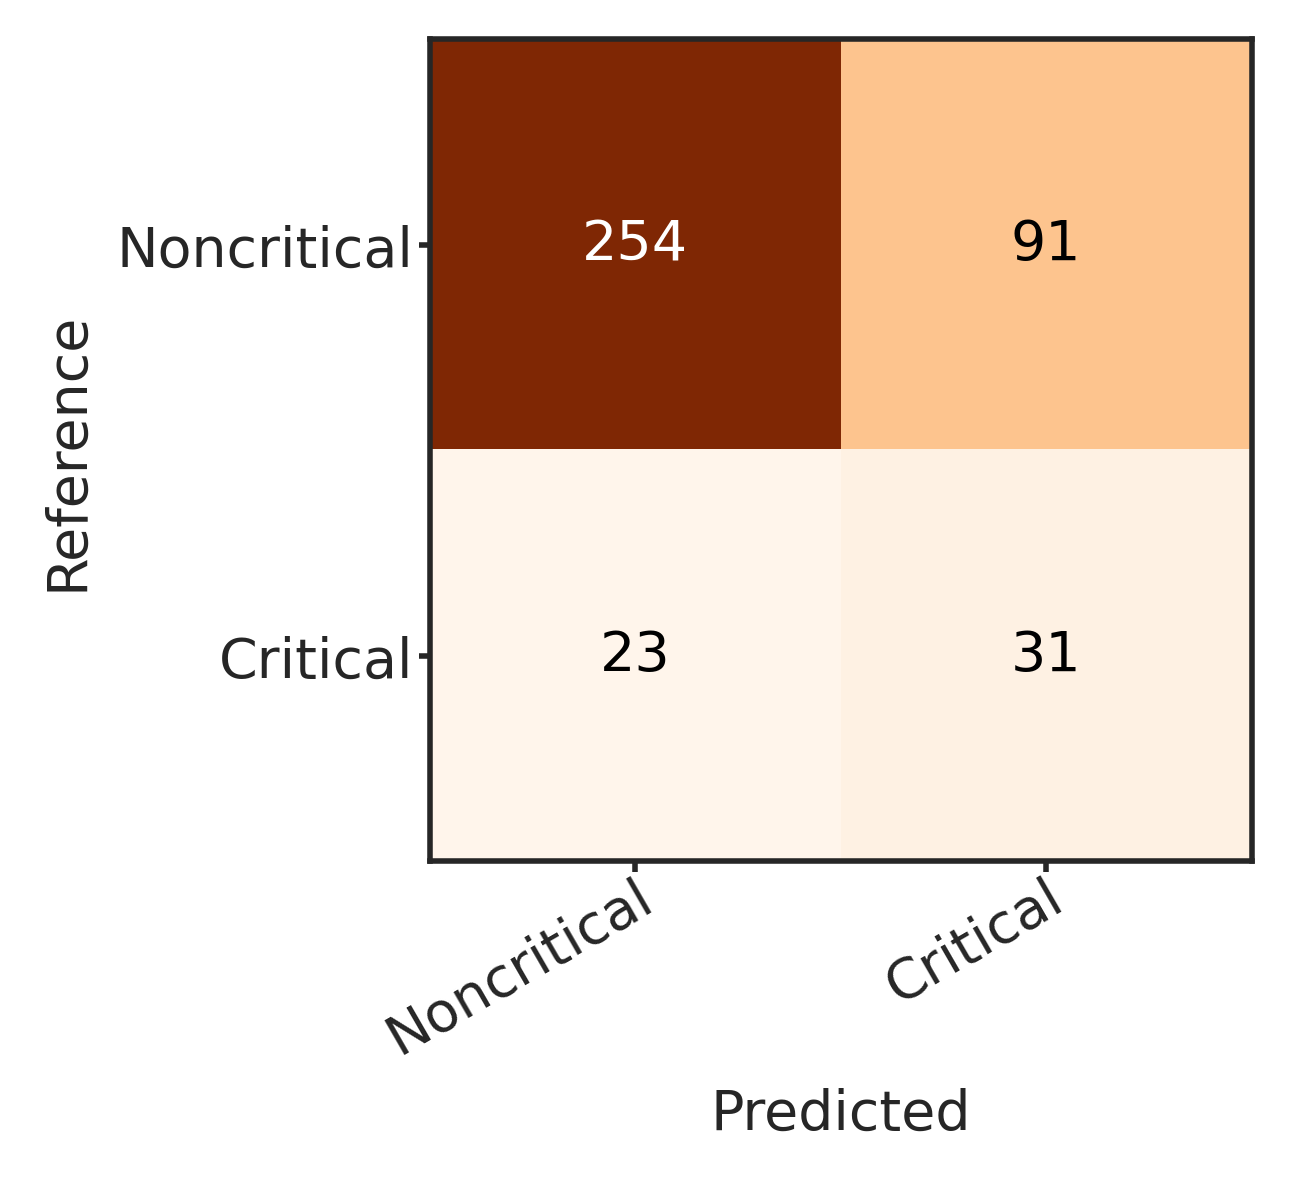

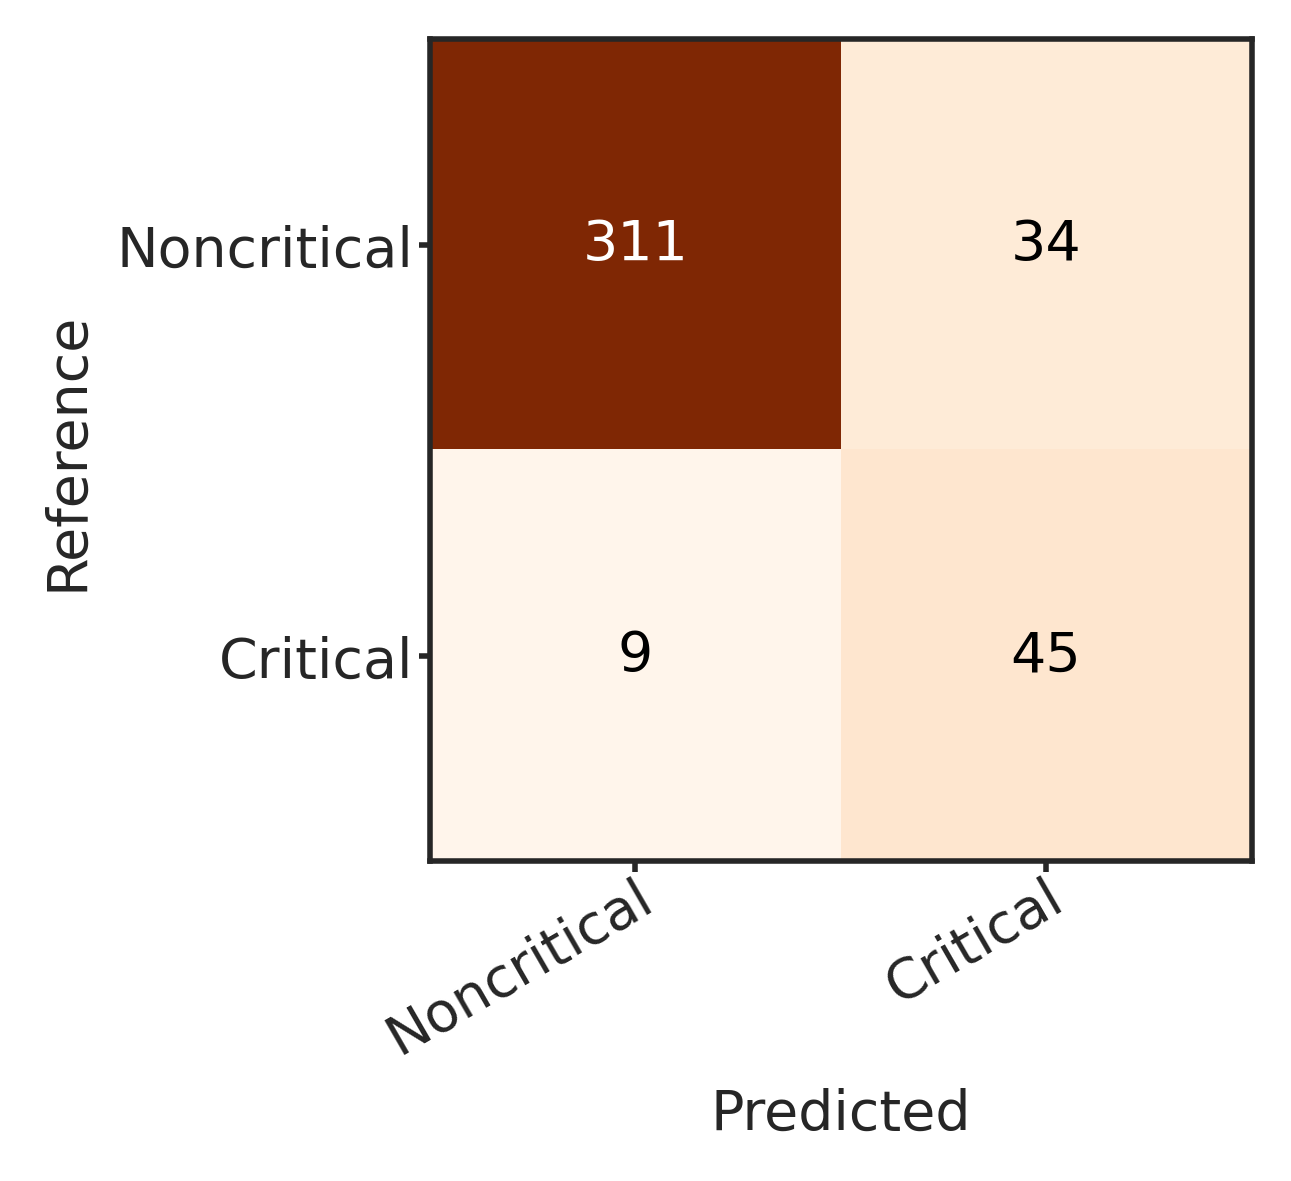

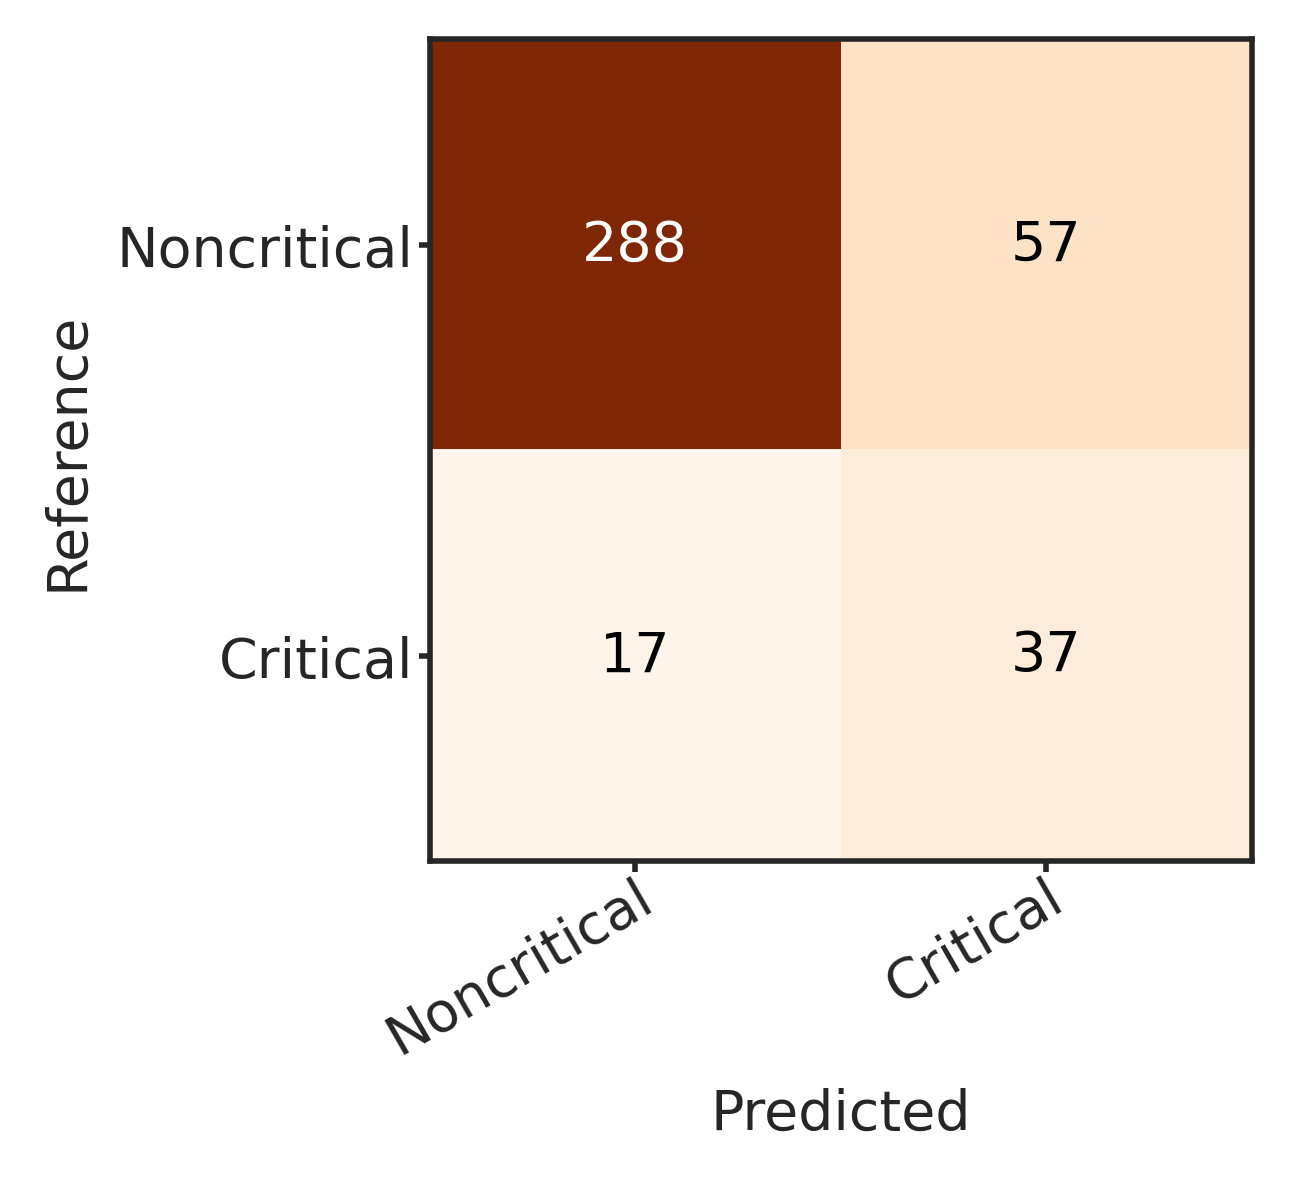

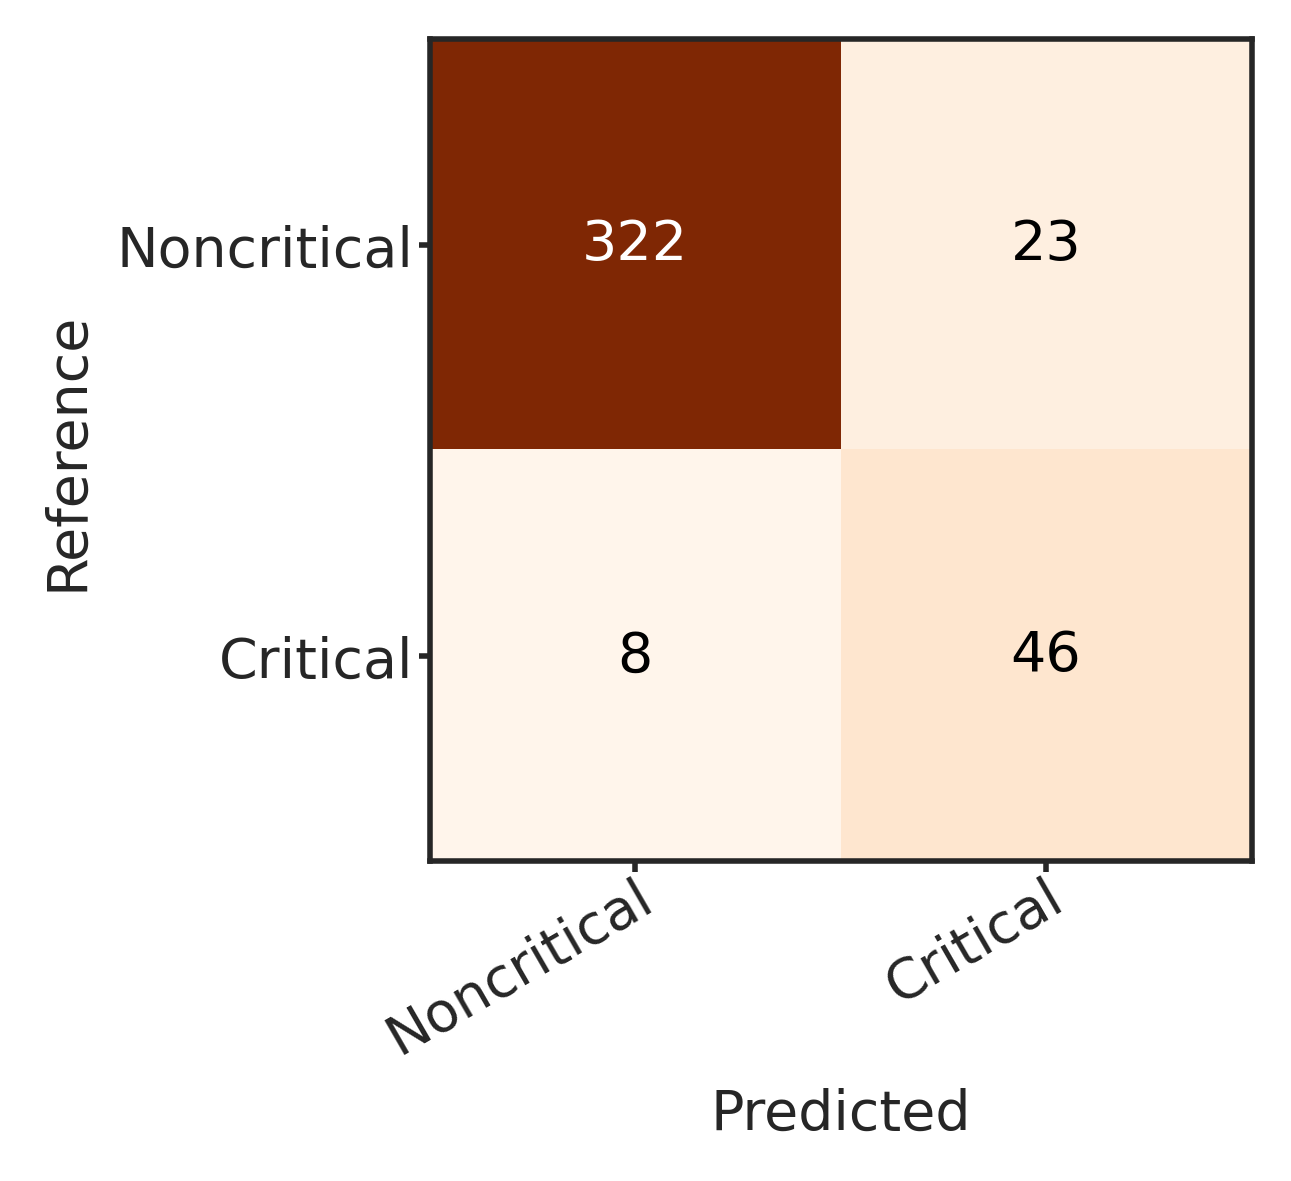

In [46]:
target_names = ['Noncritical','Critical']

prec_labels = []
reca_labels = []
mcc_labels = []
spe_labels = []
bacc_labels = []
npv_labels = []
fdr_labels = []

for i_idx, i_feat_type in enumerate(feat_types.split(',')):
    
    i_feat_type = i_feat_type.strip()
    cm = metrics.confusion_matrix(perf_mean_label['y_true'], perf_mean_label[i_feat_type])
    tn, fp, fn, tp = cm.ravel()
    
    # Precision / PPV
    prec_labels.append(metrics.precision_score(perf_mean_label['y_true'], perf_mean_label[i_feat_type]))
        
    # Recall / sensitivity
    reca_labels.append(metrics.recall_score(perf_mean_label['y_true'], perf_mean_label[i_feat_type]))
        
    # Matthews correlation coefficient (MCC)
    mcc_labels.append(metrics.matthews_corrcoef(perf_mean_label['y_true'], perf_mean_label[i_feat_type]))
        
    # Specificity
    spe_labels.append(tn*1.0 / (tn+fp))
        
    # balance acc
    bacc_labels.append(metrics.balanced_accuracy_score(perf_mean_label['y_true'], perf_mean_label[i_feat_type]))
    
    # NPV
    npv_labels.append(tn*1.0 / (tn+fn))
        
    # FDR
    fdr_labels.append(fp*1.0/(tp+fp))
    
    plot_confusion_matrix(cm,target_names,title=None,cmap=plt.get_cmap('Oranges'),normalize=False,
                      save_fname='results_plt/feat_opt_perf_cm_{}.pdf'.format(i_feat_type))


In [47]:
feat_types

'lab, fragl, tss, motif, m2model'

In [47]:
metrics_names=['AUPR','Brier','Recall_opt','Spe_opt','Precision_opt','NPV_opt',
              'MCC_opt','BACC_opt','FDR_opt']

modelss = ['LABModel', 'FRAGLModel', 'TSSModel', 'MOTIFModel','M2Model']

metrics_100iters_df = pd.read_csv('results_plt/100iters_tst_preds_399pat_allmethods_metrics.csv', sep='\t')

metric_tab = pd.DataFrame({'Model':modelss})

metric_tab['Sensitivity']=reca_labels
metric_tab['Specificity']=spe_labels
metric_tab['MCC']=mcc_labels
metric_tab['PPV'] = prec_labels

metric_tab['Balanced Accuray'] = bacc_labels
metric_tab['NPV'] = npv_labels
metric_tab['FDR'] = fdr_labels


for i_mets in metrics_names:
    lab_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==modelss[0],i_mets].values
    fragl_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==modelss[1],i_mets].values
    tss_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==modelss[2],i_mets].values
    motif_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==modelss[3],i_mets].values
    m2model_values = metrics_100iters_df.loc[metrics_100iters_df['Model']==modelss[4],i_mets].values
    
    ci95_lab = np.percentile(lab_values, [2.5, 97.5])
    ci95_fragl = np.percentile(fragl_values, [2.5, 97.5])
    ci95_tss = np.percentile(tss_values, [2.5, 97.5])
    ci95_motif = np.percentile(motif_values, [2.5, 97.5])
    ci95_m2model = np.percentile(m2model_values, [2.5, 97.5])
    '{0:.1f}-{1:.1f}'
    metric_tab[i_mets+'_95CI']=['{0:.1f}-{1:.1f}'.format(ci95_lab[0]*100,ci95_lab[1]*100),
                       '{0:.1f}-{1:.1f}'.format(ci95_fragl[0]*100,ci95_fragl[1]*100),
                       '{0:.1f}-{1:.1f}'.format(ci95_tss[0]*100,ci95_tss[1]*100),
                       '{0:.1f}-{1:.1f}'.format(ci95_motif[0]*100,ci95_motif[1]*100),
                       '{0:.1f}-{1:.1f}'.format(ci95_m2model[0]*100,ci95_m2model[1]*100)]
    
    pvalues = [
        mannwhitneyu(m2model_values, lab_values, alternative="two-sided").pvalue,
        mannwhitneyu(m2model_values, fragl_values, alternative="two-sided").pvalue,
        mannwhitneyu(m2model_values, tss_values, alternative="two-sided").pvalue,
        mannwhitneyu(m2model_values, motif_values, alternative="two-sided").pvalue
    ]

    formatted_pvalues = [f"{p:.2e}" for p in pvalues] + ['']
    metric_tab[i_mets+'_pvalue']=formatted_pvalues
    
    metric_tab[i_mets+'_m']=[lab_values.mean(), 
                             fragl_values.mean(), 
                             tss_values.mean(), 
                             motif_values.mean(), 
                             ci95_m2model.mean()]
    metric_tab[i_mets+'_sd']=[lab_values.std(), 
                             fragl_values.std(), 
                             tss_values.std(), 
                             motif_values.std(), 
                             ci95_m2model.std()]


In [49]:
metric_tab.to_csv('results_plt/100iters_tst_preds_399pat_metrics_reports.csv', sep='\t', index=False)
metric_tab

,Model,Sensitivity,Specificity,MCC,PPV,Balanced Accuray,NPV,FDR,AUPR_95CI,AUPR_pvalue,...,MCC_opt_m,MCC_opt_sd,BACC_opt_95CI,BACC_opt_pvalue,BACC_opt_m,BACC_opt_sd,FDR_opt_95CI,FDR_opt_pvalue,FDR_opt_m,FDR_opt_sd
0,LABModel,0.685185,0.878261,0.483693,0.468354,0.781723,0.946875,0.531646,46.1-86.4,9.10e-24,...,0.488726,0.115693,65.5-89.3,1.14e-19,0.779183,0.065750,29.0-66.7,3.29e-22,0.514541,0.103558
1,FRAGLModel,0.574074,0.736232,0.230397,0.254098,0.655153,0.916968,0.745902,21.7-61.7,3.46e-34,...,0.225605,0.101359,52.1-77.2,6.36e-34,0.652391,0.069546,65.1-84.4,2.50e-34,0.749694,0.052617
2,TSSModel,0.833333,0.901449,0.630778,0.569620,0.867391,0.971875,0.430380,50.1-94.3,2.42e-06,...,0.621455,0.106941,74.1-96.4,5.56e-02,0.860481,0.062594,27.6-60.6,1.69e-11,0.432197,0.095184
3,MOTIFModel,0.685185,0.834783,0.419150,0.393617,0.759984,0.944262,0.606383,28.0-75.9,9.86e-33,...,0.381204,0.109503,60.7-86.4,2.63e-27,0.736963,0.069081,50.0-75.0,1.65e-33,0.629957,0.070753
4,M2Model,0.851852,0.933333,0.710227,0.666667,0.892593,0.975758,0.333333,67.4-98.0,,...,0.692902,0.194765,77.1-98.2,,0.876482,0.105583,11.1-51.2,,0.311806,0.200694


In [52]:
metric_tab[['Specificity','Spe_opt_95CI','Spe_opt_m', 'Spe_opt_sd']]

,Specificity,Spe_opt_95CI,Spe_opt_m,Spe_opt_sd
0,0.878261,79.7-95.7,0.879275,0.041605
1,0.736232,58.7-82.6,0.714783,0.062365
2,0.901449,82.6-94.2,0.895507,0.036852
3,0.834783,73.9-88.4,0.820290,0.038942
4,0.933333,86.2-98.6,0.923732,0.061775
